In [13]:
from typing import List
import string
from spellchecker import SpellChecker
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk import pos_tag
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import inflect
import re
import contractions
from typing import Dict
from collections import defaultdict
from datetime import datetime
import pycountry
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def custom_preprocessor(text):
    lowercase_text = _lowercase_tokens(text)
    expanded_text = expand_contractions(lowercase_text)
    cleaned_text = remove_html_and_links(expanded_text)

    return cleaned_text
#==================================================================#
def custom_tokenizer(text,online=False):
    tokens, ddate = _get_tokenz(text)
    
    cleaned_tokens = _remove_punctuations(tokens)

    # apply Spell Checker for online query 
    if online:
        corrected_token = spell_checker(cleaned_tokens)
    else:
        corrected_token = cleaned_tokens

    stop_words_removed = _stop_words(corrected_token)
    
    dateNormalization = normalize_dates(ddate)
    
    tokenWithoutCountry, countryNormalization = _normalize_country_names(stop_words_removed)
    
    lemma_tokens = _lemma_tokens(tokenWithoutCountry)
    
    return lemma_tokens + dateNormalization + countryNormalization
#==================================================================#
def _lowercase_tokens(text:list) -> str:
    lowercase_words = text.lower()
    
    return lowercase_words 
#==================================================================#
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    
    return expanded_text
#==================================================================#
def remove_html_and_links(text):
    clean_text = re.sub(r'<.*?>', '', text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    
    return clean_text
#==================================================================#
def _get_tokenz(text: str) -> list:
    date_pattern = r'(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})|'\
                r'(\d{4}[-/]\d{1,2}[-/]\d{1,2})|'\
                r'(\d{1,2}\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+\d{2,4})|' \
                r'((jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+\d{1,2},\s+\d{2,4})|' \
                r'(\d{1,2}\s+(january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{2,4})|' \
                r'((january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2},\s+\d{2,4})'

    matches = re.findall(date_pattern, text)

    dates=[]
    for match in matches:
        date = next(item for item in match if item) 
        dates.append(date)
        text = text.replace(date,"")

    tokens = word_tokenize(text)

    return tokens , dates 
#==================================================================#
def _remove_punctuations(tokens: list) -> list:
    tokenizer = RegexpTokenizer(r'\w+')
    cleaned_token = tokenizer.tokenize(' '.join(tokens))
    
    return cleaned_token
#==================================================================#
def _stop_words(tokens:list) -> list:
    stopwords = nltk_stopwords.words("english")
    filtered_tokens = [token for token in tokens if token not in stopwords]
    
    return filtered_tokens
#==================================================================#
def get_wordnet_pos(tag_parameter):
    tag = tag_parameter[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

def _lemma_tokens(tokens:list) -> list:
    tagged_tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    return lemmatized_words
#==================================================================#
def normalize_dates(tokens:list) -> list:
    date_pattern = r'(\d{1,2}[-/]\d{1,2}[-/]\d{2,4})|' \
                    r'(\d{4}[-/]\d{1,2}[-/]\d{1,2})|' \
                    r'(\d{1,2}\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+\d{2,4})|' \
                    r'((jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s+\d{1,2},\s+\d{2,4})|' \
                    r'(\d{1,2}\s+(january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{2,4})|' \
                    r'((january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2},\s+\d{2,4})'

    format_strings = ['%d-%m-%Y', '%d/%m/%Y', '%d.%m.%Y', '%Y-%m-%d', '%Y/%m/%d', '%Y.%m.%d', '%d %b %Y', '%b %d, %Y',
                        '%d %B %Y', '%B %d, %Y', '%m/%d/%Y', '%m-%d-%Y', '%m.%d.%Y', '%d-%m-%y', '%d/%m/%y', '%d.%m.%y',
                        '%y-%m-%d', '%y/%m/%d', '%y.%m.%d', '%d %b %y', '%b %d, %y',
                        '%d %B %y', '%B %d, %y', '%m/%d/%y', '%m-%d-%y', '%m.%d.%y']

    for token in tokens:
        matches = re.findall(date_pattern, token)
        if matches:
            match = next(item for item in matches[0] if item)
            for fmt in format_strings:
                try:
                    date_obj = datetime.strptime(match, fmt)
                    break  
                except ValueError:
                    pass
            else:
             continue  
            normalized_date = date_obj.strftime('%Y-%m-%d')
            position = tokens.index(token)
            tokens[position]=token.replace(match, normalized_date)
            
    return tokens
#==================================================================#
def _normalize_country_names(tokens:list) -> list:
    country_codes = set(country.alpha_3 for country in pycountry.countries)
    countryName=[]
    for token in tokens.copy():
        if token.upper() in country_codes:
            try:
                country = pycountry.countries.lookup(token.upper())
                tokens.remove(token)
                countryName.append(country.name)
            except LookupError:
                pass

    return tokens,countryName
#=============================================================================================================================================#
def spell_checker(tokens:list) -> list:
    spell = SpellChecker()
    misspelled = spell.unknown(tokens)
   # print("--------",misspelled)
    for i, token in enumerate(tokens):
        if token in misspelled:
            suggestions = spell.candidates(token)
            #print("hello",suggestions)
            if suggestions:
                corrected = spell.correction(token)
                if corrected is not None:
                    tokens[i] = corrected
                    
    return tokens

In [14]:
from typing import List
import string
import pandas as pd
import re
from typing import Dict
from collections import defaultdict

def load_corpus(dataset:str) -> Dict:
        data_dict = {}
        if dataset == "wikir":
                path = r'C:\Users\juman\Downloads\dataset\wikIR1k\wikIR1k\documents.csv'
                data = pd.read_csv(path, index_col=False)
                data_dict = {row["id_right"]: row["text_right"] for index, row in data.iterrows()} #second way

        elif dataset == "lotte":
                path = r'C:\Users\juman\Downloads\dataset\lifestyle\lifestyle\dev\collection.tsv'
                data = pd.read_csv(path, sep='\t', header=None)
                data_dict =  {row[0]: row[1] for index, row in data.iterrows()} 

        return data_dict
#---------------------------------------------------------------------------------#
def load_queries(dataset:str) -> Dict:
        queries_dict = {}
        if dataset == "wikir":
                path = r'C:\Users\juman\Downloads\dataset\wikIR1k\wikIR1k\training\queries.csv'
                data = pd.read_csv(path, index_col=False)
                queries_dict = {row["id_left"]: row["text_left"] for index, row in data.iterrows()} #second way

        elif dataset == "lotte": 
                path1 = r'C:\Users\juman\Downloads\dataset\lifestyle\lifestyle\dev\questions.search.tsv'
                data = pd.read_csv(path1, sep='\t', header=None)
                queries_dict =  {row[0]: row[1] for index, row in data.iterrows()} 

        return queries_dict
#--------------------------------------------------------------------------------------#
def load_qrels(dataset:str):
        qrels_dict = {}
        if dataset == "lotte":
                path = r'C:\Users\juman\Downloads\dataset\lifestyle\lifestyle\dev\qas.search.jsonl'
                df = pd.read_json(path,lines=True)
                qrels_dict = pd.Series(df['answer_pids'].values, index=df['qid']).to_dict()

        else:
                path= r'C:\Users\juman\Downloads\dataset\wikIR1k\wikIR1k\training\BM25.qrels.csv'
                df = pd.read_csv(path)
                qrels_dict = df.groupby('id_left')['id_right'].apply(list).to_dict()

        return  qrels_dict

In [18]:
corpus=load_corpus("lotte")

In [19]:
import pickle

with open('lotte_tfidf_vectorizer_object.pkl', 'rb') as file:
        tfidf_vectorizer = pickle.load(file)

with open('lotte_dtm.pkl', 'rb') as file:
        tfidf_matrix = pickle.load(file)

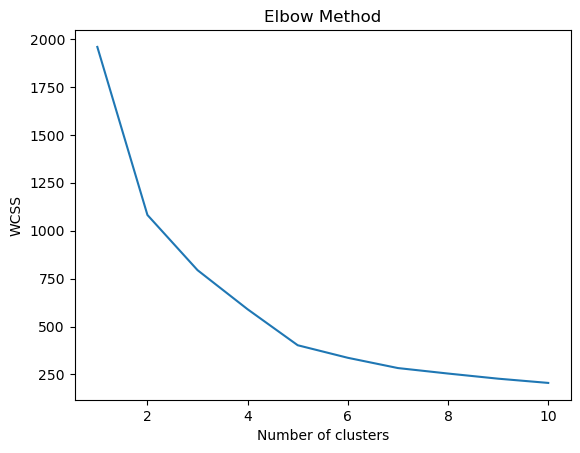

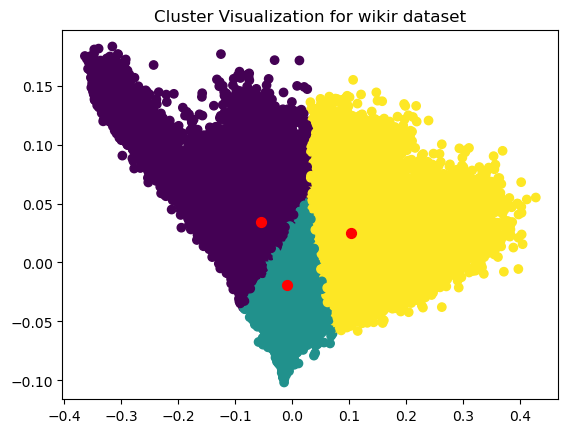

In [17]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

svd = TruncatedSVD(n_components=2, random_state=42)
data_scaled = svd.fit_transform(tfidf_matrix)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply k-means with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
labels = kmeans.fit_predict(data_scaled)
centroids = kmeans.cluster_centers_

# Plot the clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=50, c='red')
plt.title('Cluster Visualization for wikir dataset')
plt.show()

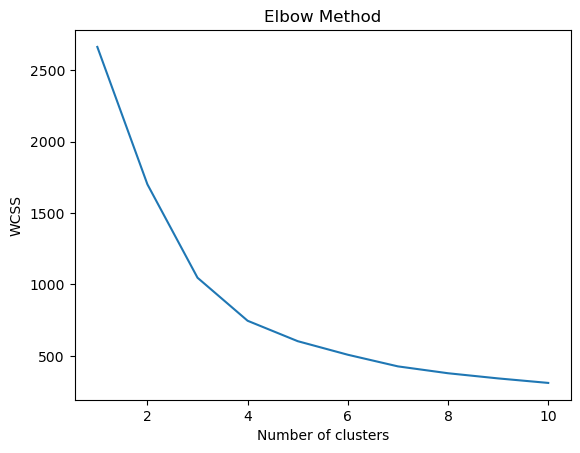

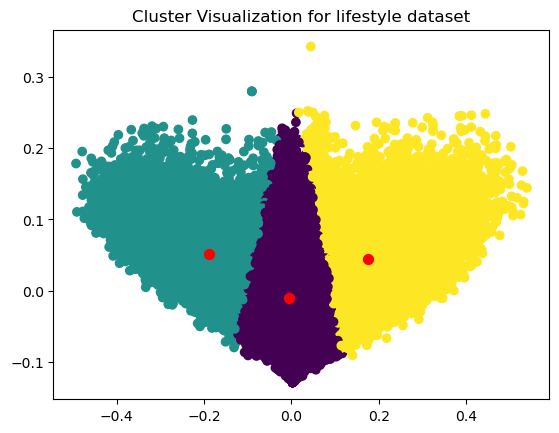

In [20]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

svd = TruncatedSVD(n_components=2, random_state=42)
data_scaled = svd.fit_transform(tfidf_matrix)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply k-means with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
labels = kmeans.fit_predict(data_scaled)
centroids = kmeans.cluster_centers_

# Plot the clusters
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
centroids_pca = pca.transform(centroids)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=50, c='red')
plt.title('Cluster Visualization for lifestyle dataset')
plt.show()